You can find the place where/how I created the histogram in the notebook at 
/epyc/projects/sso-lc/notebooks/id_objlist.ipynb  (I think you would be able to either copy the notebook and look at the contents or open it directly on the epyc jupyterhub if you can navigate to it). 

The LCDB data in the histogram is probably easiest to deal with by using a snippet of the code (and directions for downloading the data files) here - https://github.com/dirac-institute/sso_tools/blob/master/sso_tools/catalogs/catalog_utils.py (see read_lcdb ... you could either just copy/paste that snippet or use the whole sso_tools package, which would be available in the "Python 3 (sso-lc)" jupyter kernel available in the 'kernel' dropdown menu on the epyc jupyterhub. .. if you don't have sso-lc as one of the options, there are a few lines you could go through to make it available if you'd like - we could also add any packages you're using there as well, and then it would be 'one-stop LC shopping' which would be nice).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def read_lcdb(filename='LC_SUM_PUB.TXT'):
    """Read LCDB file tabulating periods and associated information.
    LCDB available from:
    http://www.minorplanet.info/lightcurvedatabase.html
    Please see that page for citation information.
    Warner, B.D., Harris, A.W., Pravec, P. (2009). Icarus 202, 134-146.
    Updated <Date of last update>. http://www.MinorPlanet.info/lightcurvedatabase.html
    The Asteroid Lightcurve Database is a listing of asteroid lightcurve parameters and other information,
    e.g., estimated/measured diameters, absolute magnitudes (H), phase slope parameters (G), albedos, + more.
    Parameters
    ----------
    filename : str, opt
        The full path to the LCDB file (LC_SUM_PUB.TXT or similarly formatted files)
    Returns
    -------
    pandas.DataFrame
    """
    names = ['numberId', 'new', 'Name', 'Desig', 'family', 'Csource', 'class', 'Dsource',
            'Dflag', 'diameter','Hsource', 'H', 'Hband', 'Asource', 'Albedoflag',
            'albedo', 'Pflag', 'period', 'Pdescr','Ampflag', 'AmpMin', 'AmpMax',
            'U', 'notes', 'binary', 'priv' , 'pole', 'sparse', 'widefield']
    colspecs = [(0, 7), (8, 9), (10, 40), (41, 61), (62, 70), (71, 72), (73, 78),
                (79, 80), (81, 82), (83, 92), (93, 94), (95, 100), (101, 102),
                (104, 105), (106, 107), (108, 114), (115, 116), (117, 130), (131, 146),
                (147, 148), (149, 153), (154, 158), (159, 161),(162, 167), (168, 171),
                (172, 175), (176, 179), (180, 182), (183, 184)]
    lcdata = pd.read_fwf(filename, index_col=False, skiprows=5, names=names, colspecs=colspecs)
    objId = lcdata.query('numberId == numberId')['numberId'].astype('int').astype('str')
    objId2 = lcdata.query('numberId != numberId and Desig == Desig')['Desig']
    objId3 = lcdata.query('numberId != numberId and Desig != Desig')['Name']
    t = pd.concat([objId, objId2, objId3])
    lcdata = lcdata.merge(t.to_frame(name='objId'), left_index=True, right_index=True)
    lcdata['Frequency'] = 1.0/lcdata.period
    # Map flags to ints.
    tmp = lcdata.new.values
    tmp = np.where(tmp == '*', 1, 0)
    lcdata.new = tmp
    tmp = lcdata.sparse.values
    tmp = np.where(tmp == 'Y', 1, 0)
    lcdata.sparse = tmp
    tmp = lcdata.widefield.values
    tmp = np.where(tmp == 'Y', 1, 0)
    lcdata.widefield = tmp
    return lcdata



In [3]:
lcdb = read_lcdb("LCLIST_PUB_2019JAN/LC_SUM_PUB.TXT")

In [8]:
# prior period distribution for plotting
x = np.linspace(0, 50/24., 1000)
p_period = scipy.stats.lognorm(4/24., (12/24.)).pdf((x))

In [9]:
p_period

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

/home/christina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/christina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


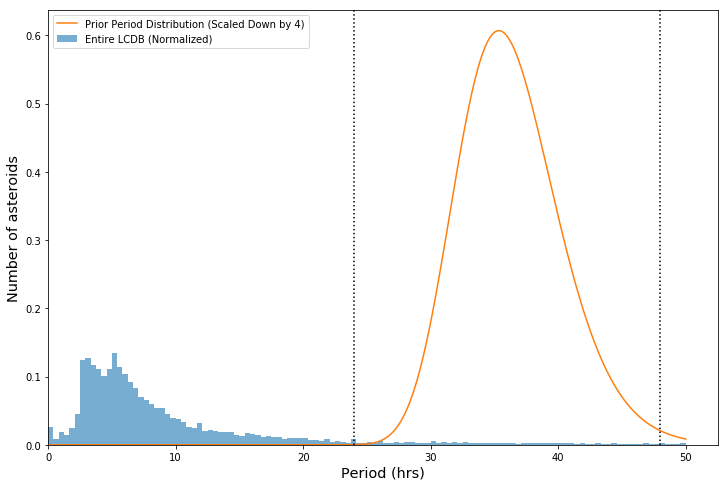

In [10]:
fig, ax = plt.subplots(1,1, figsize=[12,8])

plt.hist(lcdb.period.values, bins=120, range=[0, 50], alpha=0.6, label='Entire LCDB (Normalized)', density=True)
plt.plot(x*24., p_period/4., label='Prior Period Distribution (Scaled Down by 4)')
#ax.set_yscale('log')
plt.axvline(24.0, color='k', linestyle=':')
plt.axvline(48.0, color='k', linestyle=':')
plt.xlabel('Period (hrs)', fontsize='x-large')
plt.ylabel('Number of asteroids', fontsize='x-large')
plt.xlim(xmin=0)
plt.legend()
plt.show()

/home/christina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/christina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0, 63.0)

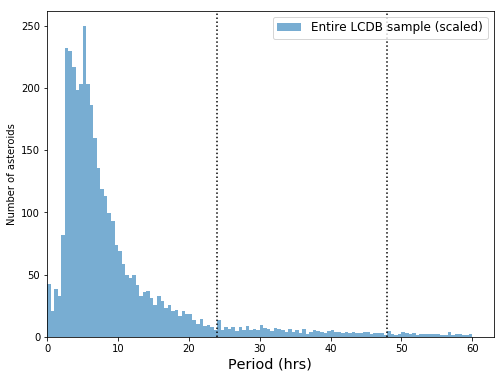

In [17]:
plt.figure(figsize=(8, 6))

n,b,p = plt.hist(lcdb.period.values, bins=120, range=[0, 60],  weights=0.2*np.ones(len(lcdb.period.values)), 
                 alpha=0.6, label='Entire LCDB sample (scaled)')
plt.legend(loc='upper right', fancybox=True, fontsize='large')
plt.axvline(24.0, color='k', linestyle=':')
plt.axvline(48.0, color='k', linestyle=':')
plt.xlabel('Period (hrs)', fontsize='x-large')
plt.ylabel('Number of asteroids')
plt.xlim(xmin=0)